# Titanic: Machine Learning from Disaster
The sinking of the RMS Titanic is one of the most infamous shipwrecks in history.  On April 15, 1912, during her maiden voyage, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 passengers and crew. This sensational tragedy shocked the international community and led to better safety regulations for ships.

One of the reasons that the shipwreck led to such loss of life was that there were not enough lifeboats for the passengers and crew. Although there was some element of luck involved in surviving the sinking, some groups of people were more likely to survive than others, such as women, children, and the upper-class.

In this challenge, we are tasked to complete the analysis of what sorts of people were likely to survive. In particular, we ask you to apply the tools of machine learning to create a binary classification model capable of predicting which passengers survived the tragedy.

In [112]:
import os
import warnings 
warnings.simplefilter("ignore")
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

## Data Exploration and Feature Engineering

In [231]:
df = pd.read_csv(os.path.join('source_data', 'train.csv'))  # data frame of training data supplied by kaggle
df.head()  # first five rows of data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [232]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


### Data Cleaning and Feature Engineering

In [233]:
df.isna().any()  # Review Columns (Features) Available and Discover if any information is missing

PassengerId    False
Survived       False
Pclass         False
Name           False
Sex            False
Age             True
SibSp          False
Parch          False
Ticket         False
Fare           False
Cabin           True
Embarked        True
dtype: bool

In [234]:
sex_mapping = {'male': 0, 'female': 1}  # Codify and map Sex strings to integer values
df['Sex'] = df['Sex'].map(sex_mapping)

In [235]:
df["Age"].fillna(28.0, inplace=True)  # Replace null data in Age column with the median Age = 28.0

In [236]:
# Add a Z-Score column for Fare data because it has outliers that skew some classification models. 
df['FareZ'] = (df['Fare'] - df['Fare'].mean()) / df['Fare'].std()
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FareZ
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,S,-0.502163
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,C,0.786404
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,-0.488580
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,S,0.420494
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,S,-0.486064


#### Data Dictionary
<ol>
    <li><b>PassengerId</b>: 	Passenger unique ID, useful for submission of solution</li>
    <li><b>Survived</b>: 	Binary value for survived:	0 = No, 1 = Yes</li>
    <li><b>Pclass</b>: 	 	Ticket class 	1 = 1st, 2 = 2nd, 3 = 3rd</li>
    <li><b>Name</b>: 	 	Passenger's Name - string</li>
    <li><b>Sex</b>: Passenger's Sex</li>
    <li><b>Age</b>: 	 	Passenger's Age in years 	</li>
    <li><b>SibSp</b>: 	 	# of siblings / spouses aboard the Titanic 	</li>
    <li><b>Parch</b>: 	 	# of parents / children aboard the Titanic 	</li>
    <li><b>Ticket</b>: 	 	Ticket number 	</li>
    <li><b>Fare</b>: 	 	Passenger fare 	</li>
    <li><b>Cabin</b>: 	 	Cabin number 	</li>
    <li><b>Embarked</b>: 	Port of Embarkation 	C = Cherbourg, Q = Queenstown, S = Southampton</li>
</ol>

In this analysis we will be leveraging the background information that women, children, and the upper-class were more likey to survive. In this notebook, analysis will be carrying forward the obviously useful features of `Pclass`, `Sex`, and `Age` to develop a classification model along with the feature of `Survived` which is our target label. 

The data point of `Fare` may also be useful with ascertaining finer resolution on a passenger's socio-economic class, but given its distribution, is it meaningful to train and predict with? It appears to have several 0.0 values which may be glorified nulls along with what may be some erroneously high fare outliers. Models that require normalized data inputs may suffer from these outliers if data was min-max normalized so a z-score column `FareZ` was added for this feature.

`Sex` as noted, is a useful feature but currently populated with "male" and "female" strings, a column of codified data will have to be created to replace it before it is a useful feature for machine learning algorithms.

`Age` should be a useful feature but has null values present. Entries with null Age values with need feature engineering. Options include excluding rows with null `Age` values or replacing the null values with median or mean age. Initially, this notebook will proceed by replacing the null `Age` values with the median age of 28.

Regarding "women and children" trend, family connections may or may not prove to be usefulfeature for predicting survival. To that end, the features `SibSp` and `Parch` will be preserved.

Lastly, the feature `PassengerId` will also be preserved as it is an inportant feature for the logistics of the competition submission but will not be used as an input to any machine learning models as it is meaningless to survival.

The remaining features in the data, namely `Name`, `Ticket`, `Cabin`, and `Embarked` will be omitted from the remaining analyses and model training.

In [229]:
features = ["Pclass","Sex","Age","FareZ", "SibSp", "Parch"]
target = ["Survived"]
df[features+target].isna().any()  # Make sure no nulls remain in data

Pclass      False
Sex         False
Age         False
FareZ       False
SibSp       False
Parch       False
Survived    False
dtype: bool

### Feature Distributions

In [17]:
# Set some styling variables for plots
sns.set_style('whitegrid')
sns.set_palette(sns.diverging_palette(220, 10, sep=80, n=2), 2)

# Define a function to make a bar plot of survivors for each of the categories in the column.
def plot_categorical(x_column, hue_column, df):
    '''Plot a bar plot for the average survivor rate for different groups.
    x_column          (str): The column name of a categorical field.
    hue_column        (str): The column name of a second categorical field.
    df   (pandas.DataFrame): The pandas DataFrame (just use df here!)
    '''
    fig=plt.figure(figsize=(14, 8), dpi= 120, facecolor='w', edgecolor='k')
    sns.barplot(x=x_column, y='Survived', hue=hue_column, data=df, errwidth=0)
    plt.title('Survivors separated by {} and {}'.format(x_column, hue_column))
    plt.show()


# Define a function to plot the distribution for survivors and non-survivors for a continuous variable.
def plot_distribution(column, df):
    '''Plot a bar plot for the average survivor rate for different groups.
    column            (str): The column name of a continuous (numeric) field.
    df   (pandas.DataFrame): The pandas DataFrame (just use df here!)
    '''
    fig=plt.figure(figsize=(14, 8), dpi= 120, facecolor='w', edgecolor='k')
    sns.distplot(df[df['Survived'] == 1][column].dropna(), label='Survived')
    sns.distplot(df[df['Survived'] == 0][column].dropna(), label='Did not survive')
    plt.legend()
    plt.title('{} distribution'.format(column))
    plt.show()

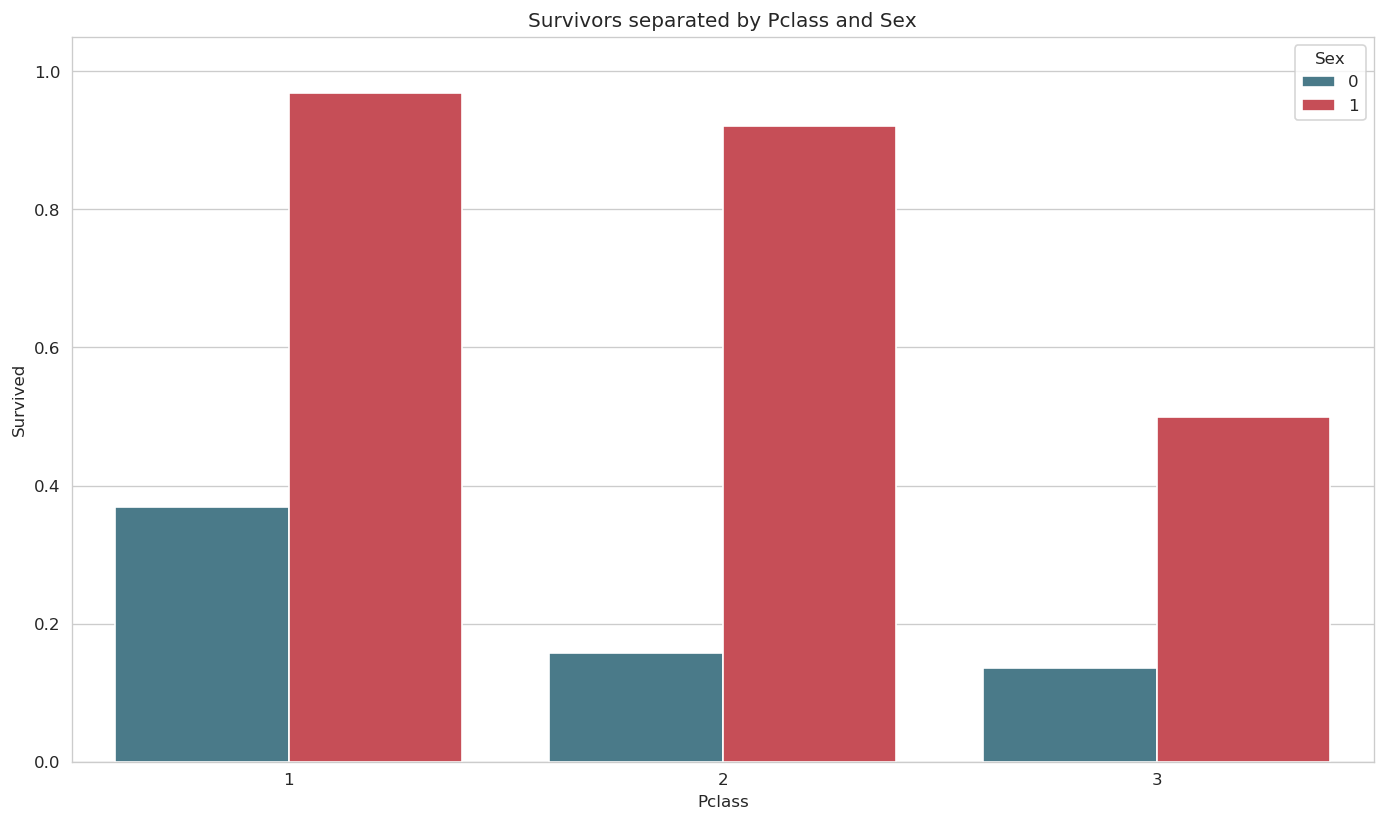

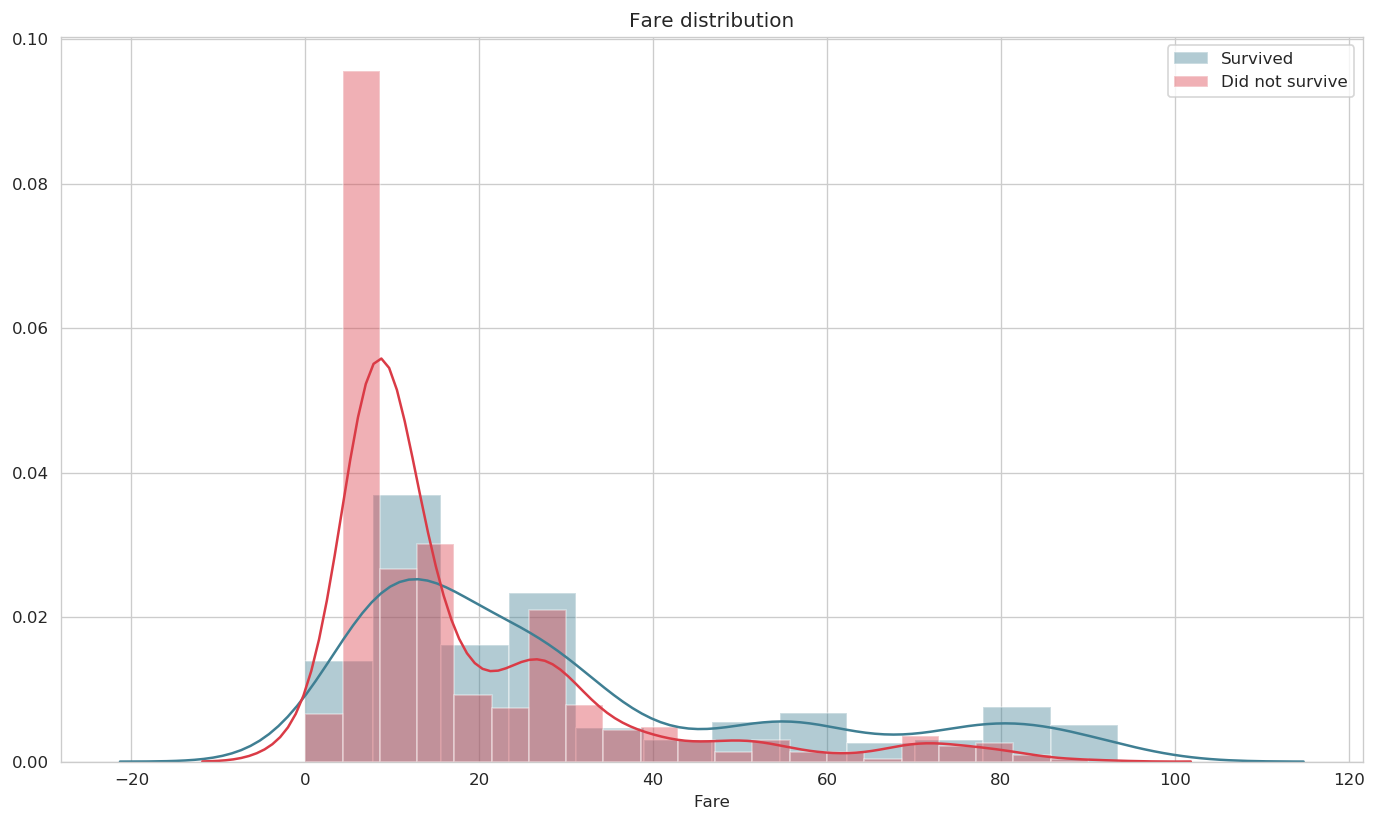

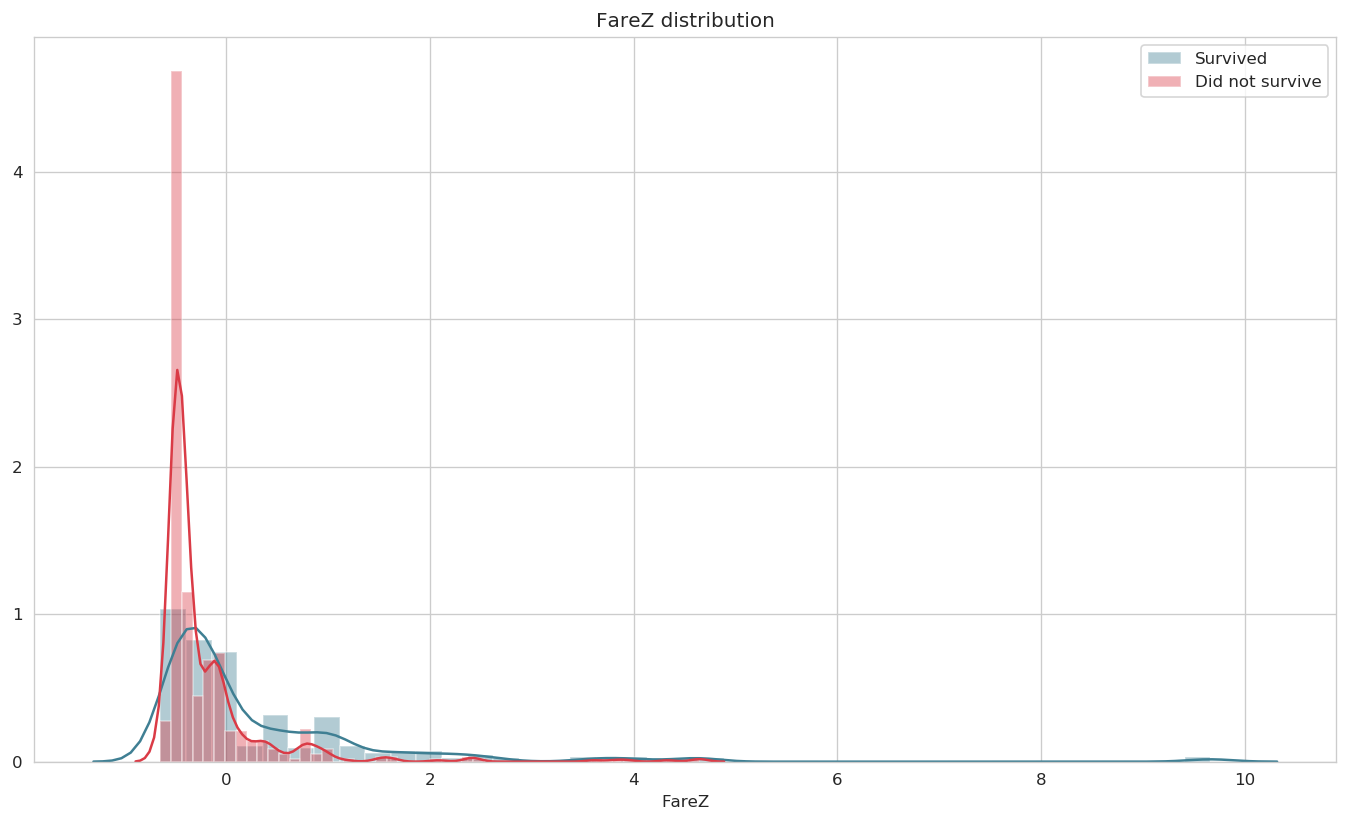

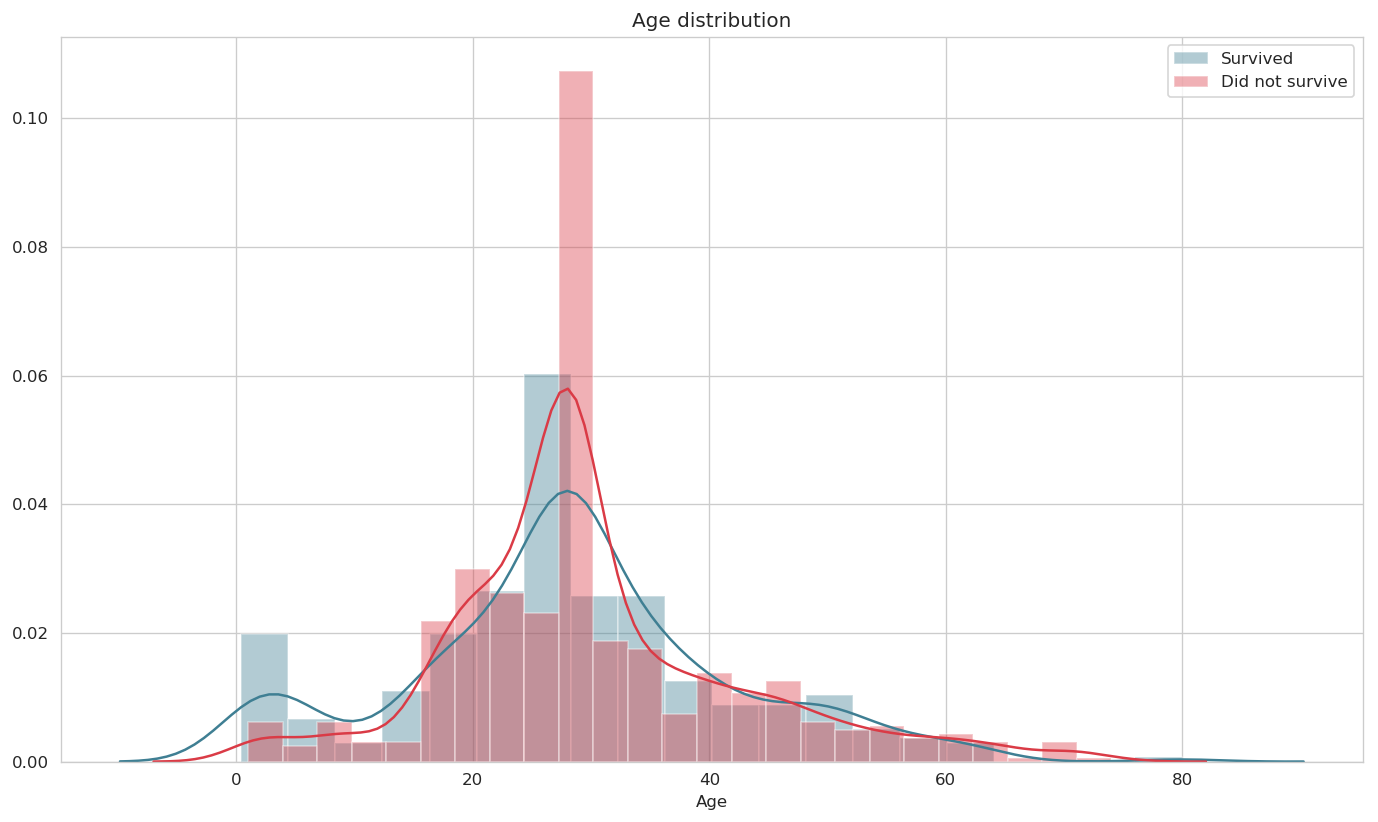

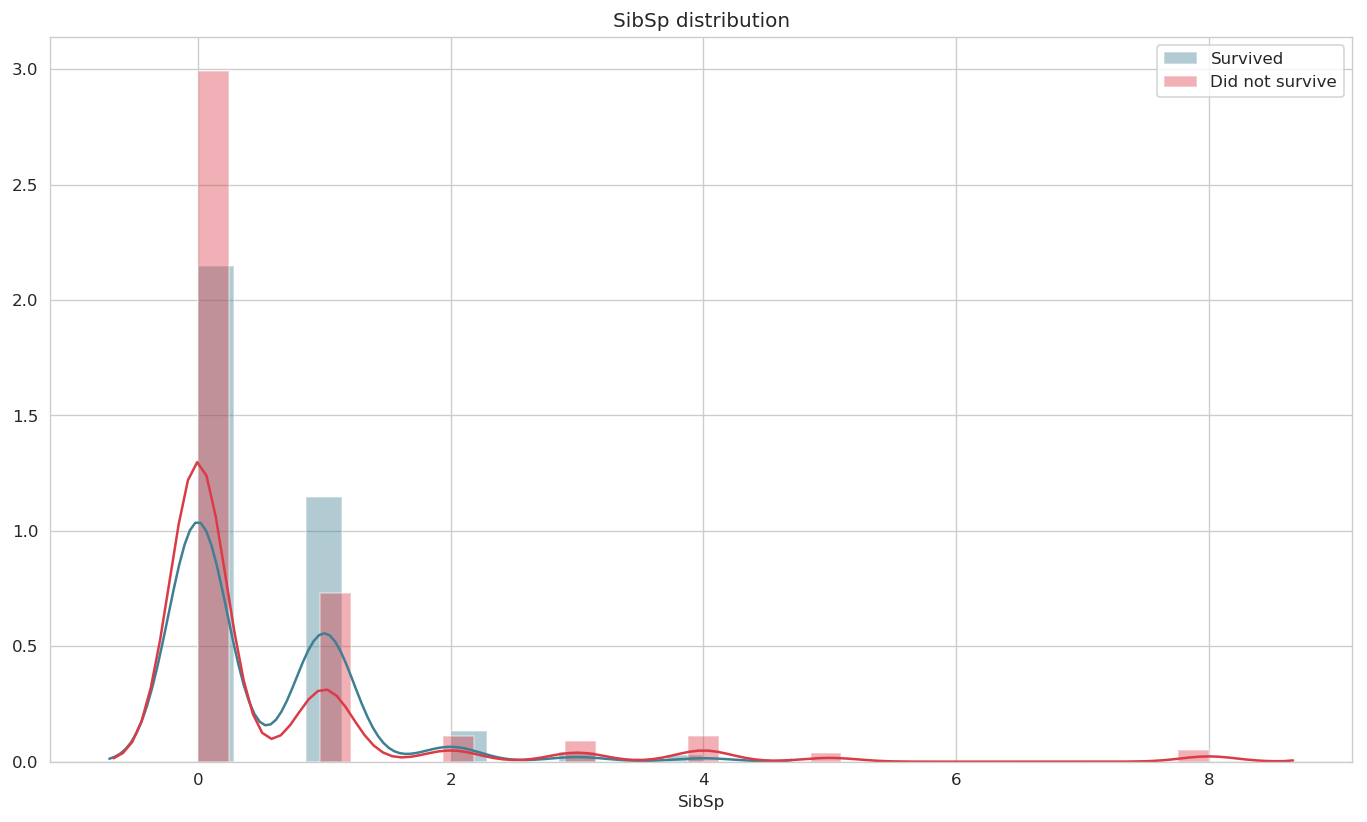

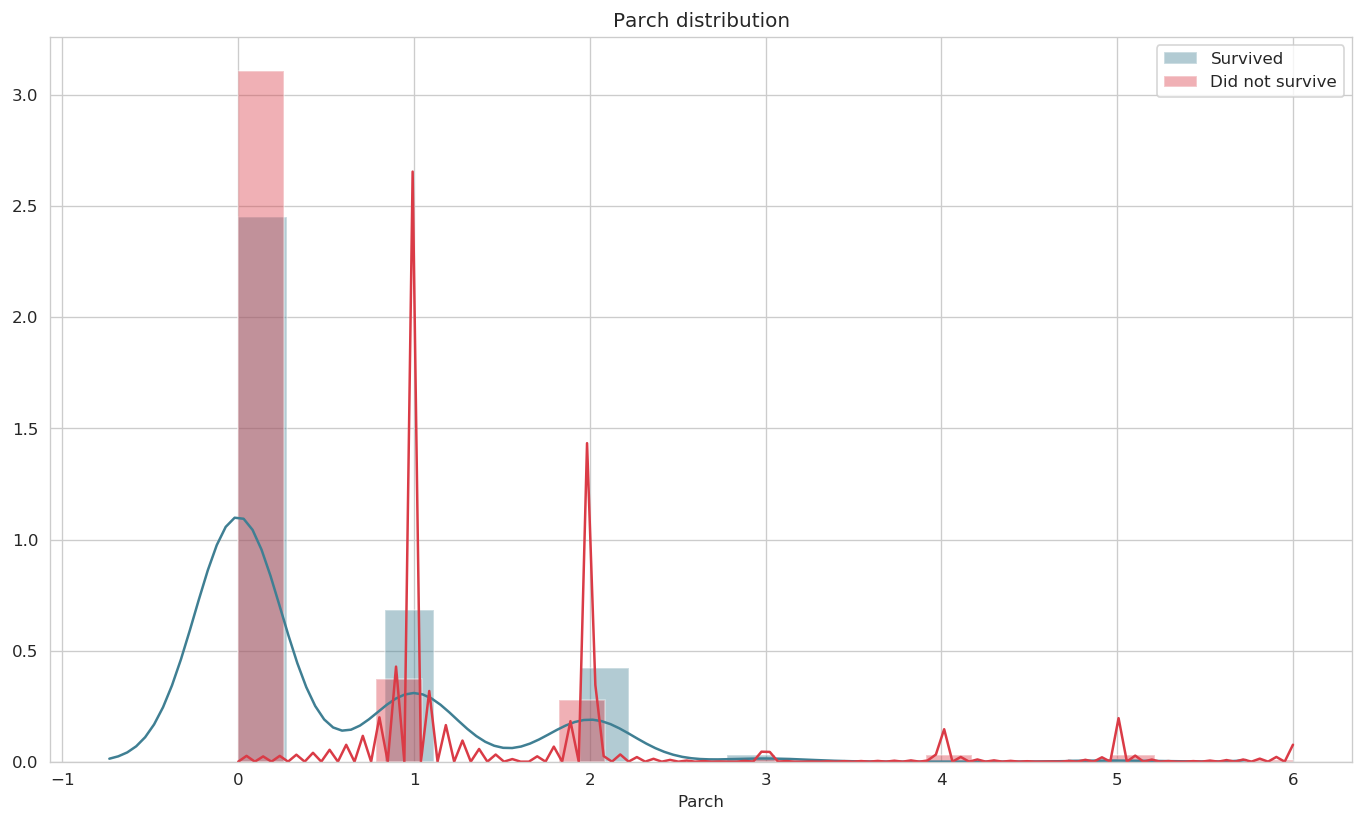

In [28]:
plot_categorical('Pclass', 'Sex', df)  # recall sex 0 = male, 1 = female
plot_distribution('Fare', df[df['Fare'] < 100]) # df[df['Fare'] < 100] simply removes some outliers!
plot_distribution('Age', df)
plot_distribution('SibSp', df)
plot_distribution('Parch', df)

### Pair Plots and Correlation Heat Maps

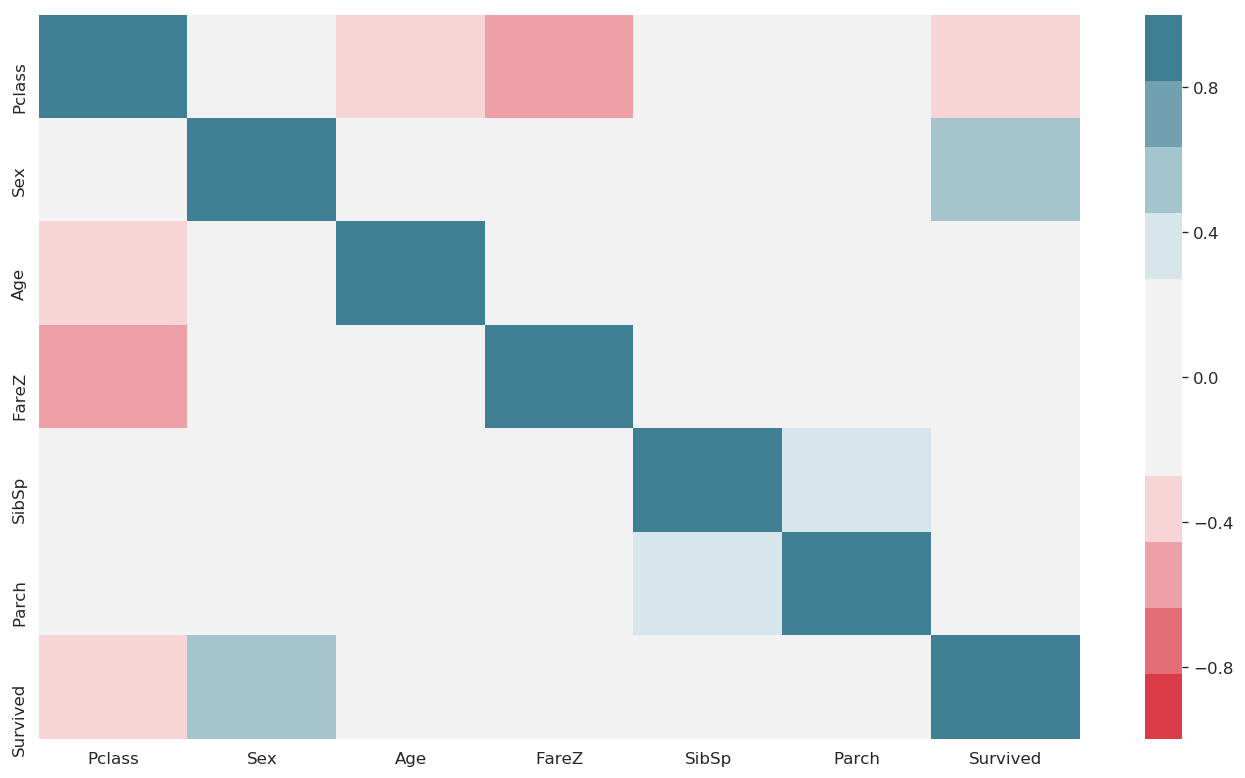

In [30]:
features = ["Pclass","Sex","Age","FareZ", "SibSp", "Parch"]
target = ["Survived"]

cor = df[features+target].corr()
f, ax = plt.subplots(figsize=(14, 8), dpi= 120, facecolor='w', edgecolor='k')
sns.set_palette("husl")
sns.heatmap(cor, vmin=-1.0, vmax=1.0, cmap=sns.diverging_palette(10, 220, sep=80, n=11)) #, cmap=blues)

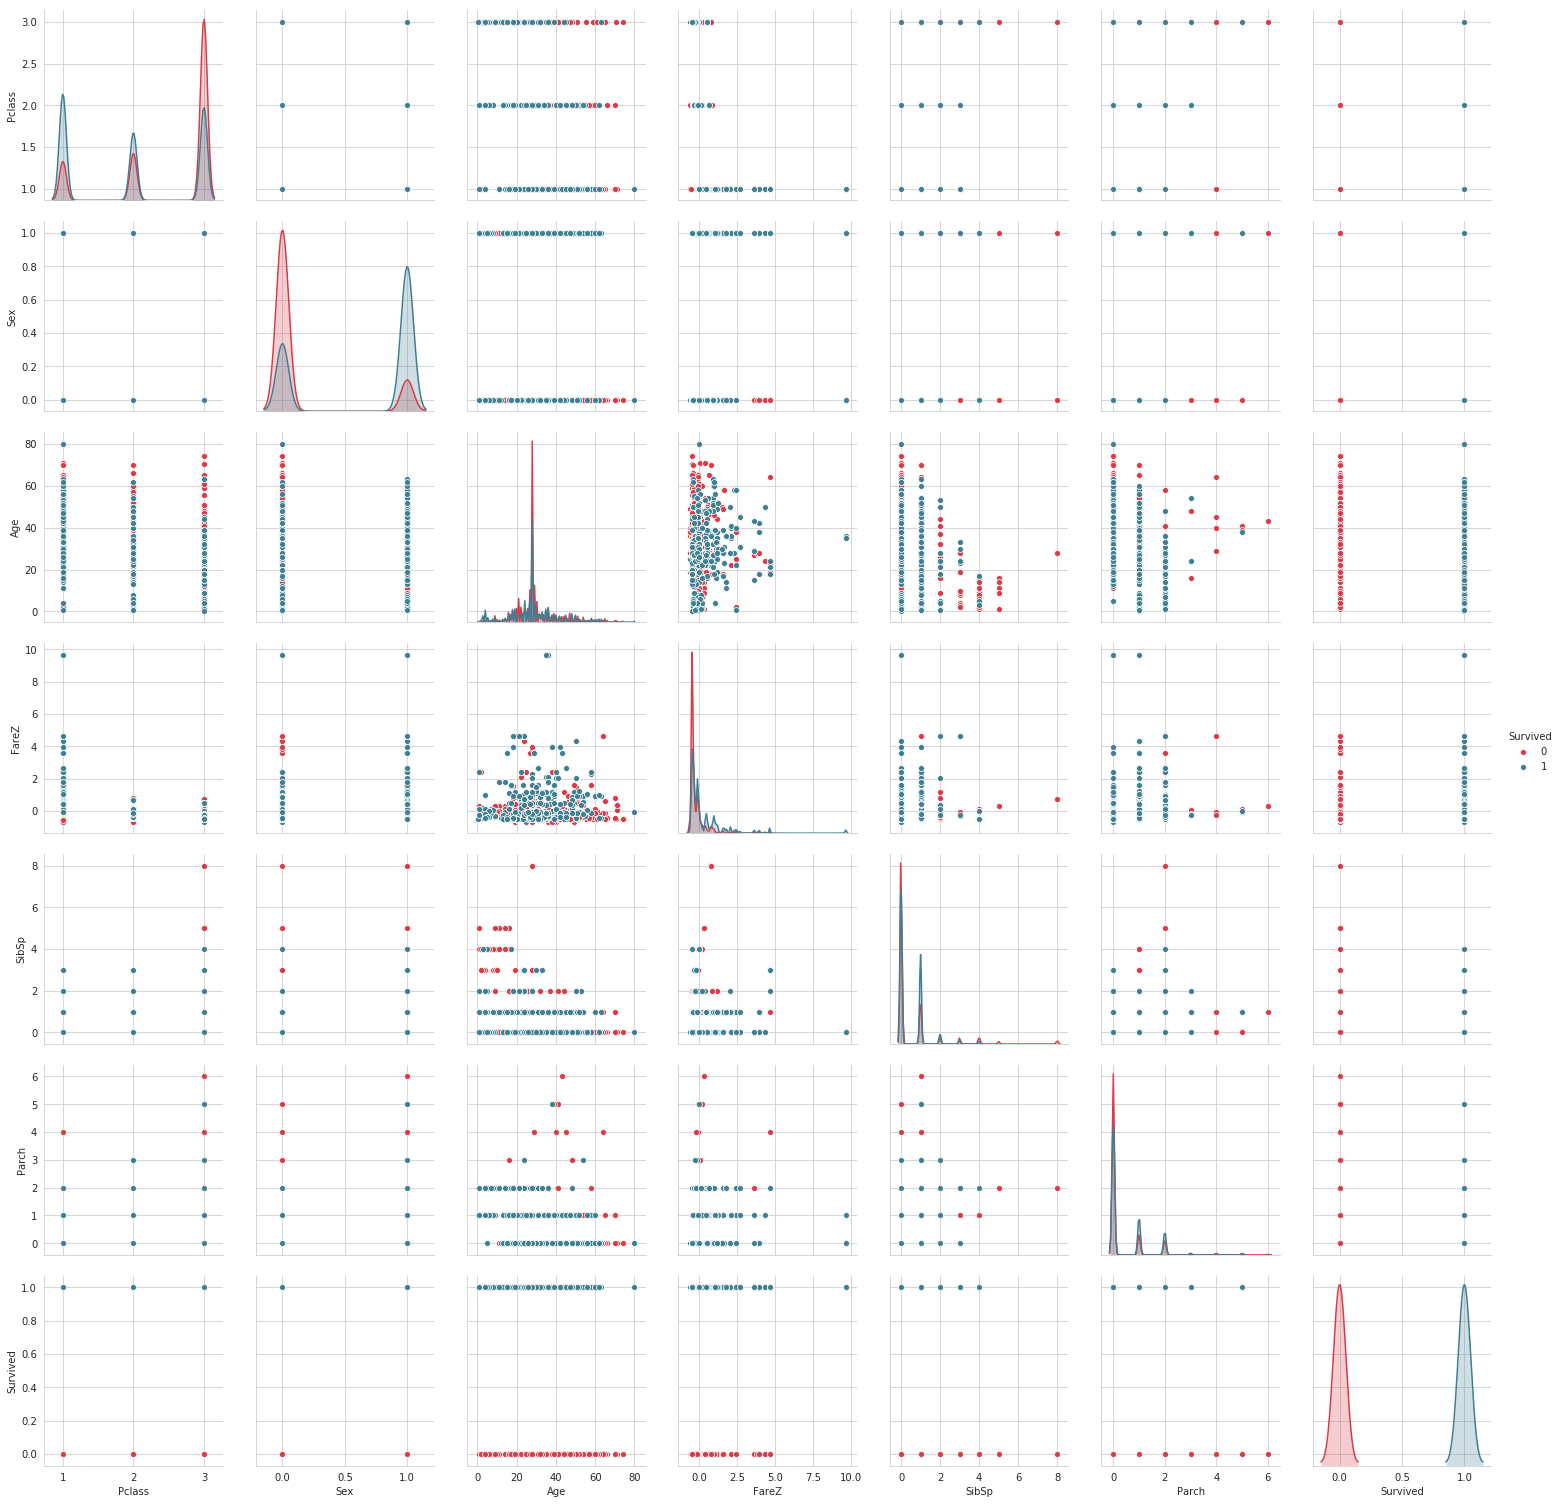

In [31]:
sns.pairplot(df[features+target], hue="Survived", palette=sns.diverging_palette(10, 220, sep=80, n=2), height=3, diag_kind="kde", diag_kws=dict(shade=True, bw=.05, vertical=False) )

### Data Observations

<ul>
    <li>There were approximately 1.5 times more third-class passengers than first or second class passengers. </li>
    <li>A high percentage of those third-class passengers were men.</li>
    <li>First class passengers skew slightly older than other classes.</li>
    <li>First-class passengers were more likely to survive than die in the tragedy. while third-class passengers had a noticeably low survival rate. </li>
    <li>More women survived than perished while it appears a very low percentage of men survived</li>
    <li>Survival tied to Age is relatively flat but it does appear than some small bias exists that shows favorable survival rates to younger passengers</li>
    </ul>
    

## Prototype and Fine Tune Promising Models
This project aims to solve a binary classification problem - predict a Titanic passenger's Survival based on their Sex, Age, Class, Fare Paid, and Family Connections on the ship. 

For this initial investigation, the following classification models will be explored:
<ul>
    <li>Logistic Regression Classifier</li>
    <li>k Nearest Neighbors Classifier</li>
    <li>Naive Bayes</li>
    <li>Decision Trees</li>   
    <li>Support Vector Machine</li>
    </ul>
    
For each prototyped model, 3-fold cross validation will be used to split the data into multiple validation sets, allowing us to be more confident that our model is good when selecting hyperparameters.

In [42]:
features = ["Pclass","Sex","Age","FareZ", "SibSp", "Parch"]
target = ["Survived"]

In [94]:
np.random.seed(0) # Set a fixed random seed so we can reproduce results.
scoring_method = "f1"  # Our competition is using the evaluation metric of the F1-Score
cv_folds = 5  # Number of folds used in cross validation

In [49]:
# import sklearn packages that will get used in many model prototypes
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import normalize
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix

### Logistic Regression Classifier

In [228]:
# Prototype the Model
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(C=1.0)  # Instantiate model object
cv_score = cross_val_score(lr, df[features], df[target].values.ravel(), cv=3, scoring=scoring_method)
print("Mean cross validation score: "+str(round(np.mean(cv_score),4)))

Mean cross validation score: 0.7141


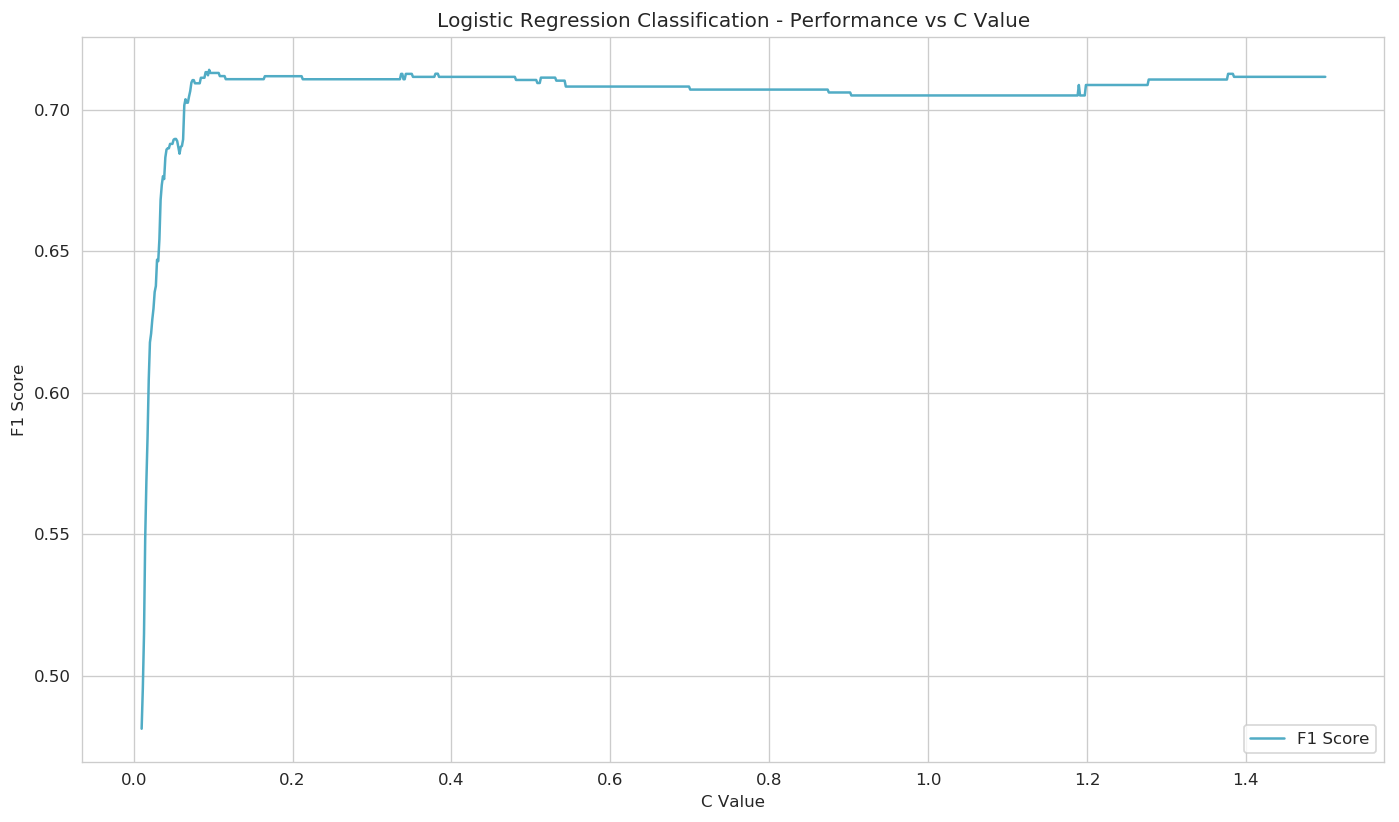

The Logistic Regression Classifier performance appears to reasonably plateau around 0.7141 when the inverse 
of regularization parameter C is greater than 0.1.


In [218]:
# Optimization of the Model
from sklearn.linear_model import LogisticRegression
C_range = np.linspace(0.01,1.5,1000)
scores = []

for c_val in C_range:
    lr = LogisticRegression(C=c_val)  # Instantiate model object
    cv_score = cross_val_score(lr, df[features], df[target].values.ravel(), cv=cv_folds, scoring=scoring_method)
    scores.append(np.mean(cv_score))
    
fig=plt.figure(figsize=(14, 8), dpi= 120, facecolor='w', edgecolor='k')
plot_labels = ['Accuracy', 'Recall', 'Precision', 'F1 Score']
blues = ["#66D7EB", "#51ACC5", "#3E849E", "#2C5F78", "#1C3D52", "#0E1E2B"]
#plt.plot(C_range, m_accuracy, '-', label=plot_labels[0], color=blues[0])
#plt.plot(C_range, m_recall, '--', label=plot_labels[1], color=blues[1])
#plt.plot(C_range, m_precision, '-.', label=plot_labels[2], color=blues[2])
#plt.plot(C_range, m_f1, ':', label=plot_labels[3], color=blues[3])
plt.plot(C_range, scores, '-', label=plot_labels[3], color=blues[1])
plt.legend(loc='lower right')
plt.title('Logistic Regression Classification - Performance vs C Value')
plt.xlabel('C Value')
plt.ylabel('F1 Score')
plt.show() 
print("The Logistic Regression Classifier performance appears to reasonably plateau around "+str(round(np.max(scores),4))+" when the inverse \nof regularization parameter C is greater than 0.1.")

### k Nearest Neighbors Classifier

In [227]:
# Prototype the Model
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5)  # Instantiate model object
cv_score = cross_val_score(knn, df[features], df[target].values.ravel(), cv=cv_folds, scoring=scoring_method)
print("Mean cross validation score: "+str(round(np.mean(cv_score),4)))

Mean cross validation score: 0.7056


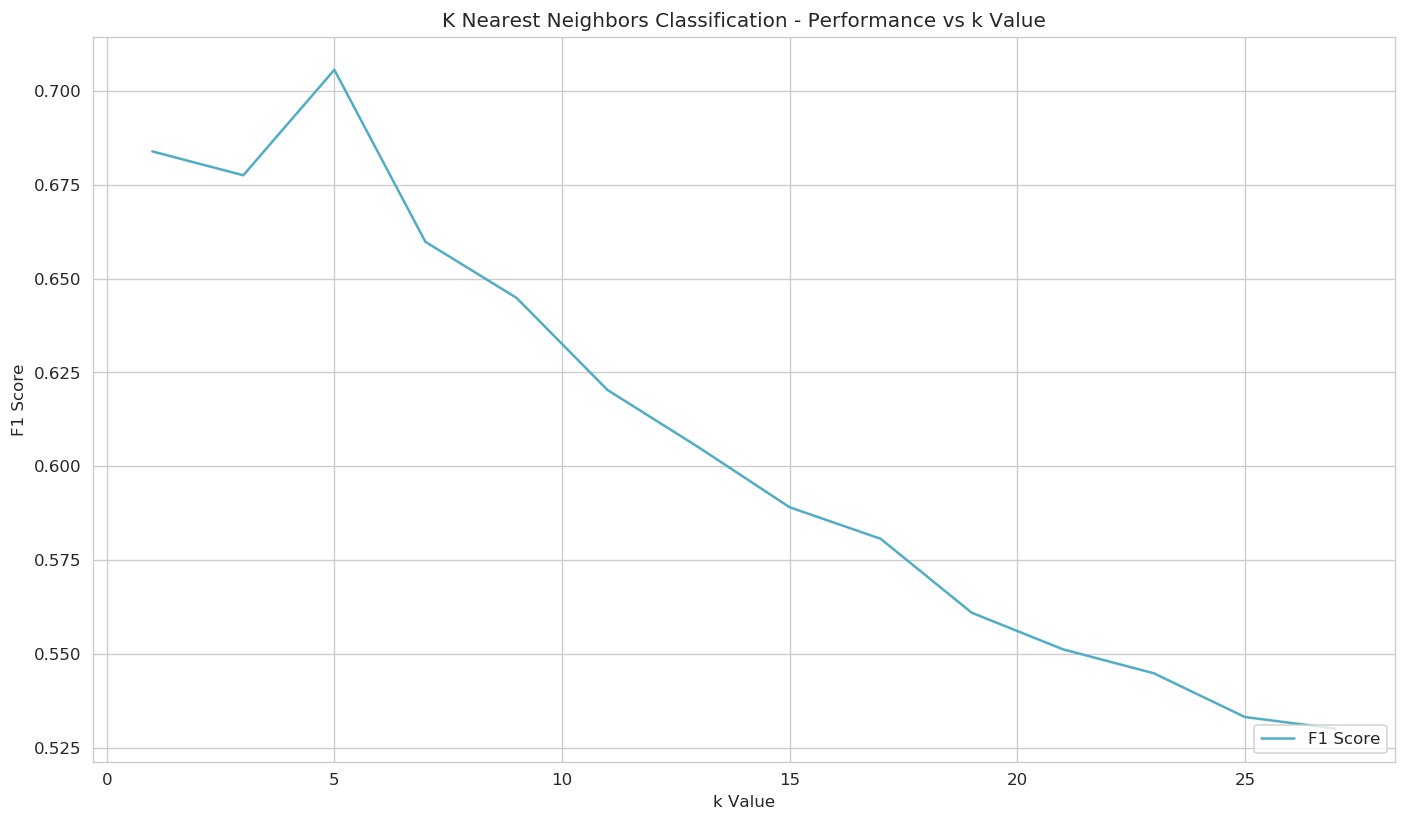

The K-Nearest Neighbors Classification Model reaches a peak F1 score of 0.7056 when k=5.


In [213]:
# Optimization of the Model
from sklearn.neighbors import KNeighborsClassifier
k_range = list(range(1,29,2))
scores = []
   
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)  # Instantiate model object
    cv_score = cross_val_score(knn, df[features], df[target].values.ravel(), cv=cv_folds, scoring=scoring_method)
    scores.append(np.mean(cv_score))
    #m_accuracy.append(accuracy_score(y_test, y_predicted))
    #m_recall.append(recall_score(y_test, y_predicted))
    #m_precision.append(precision_score(y_test, y_predicted))
    #m_f1.append(f1_score(y_test, y_predicted))

fig=plt.figure(figsize=(14, 8), dpi= 120, facecolor='w', edgecolor='k')
plot_labels = ['Accuracy', 'Recall', 'Precision', 'F1 Score']
blues = ["#66D7EB", "#51ACC5", "#3E849E", "#2C5F78", "#1C3D52", "#0E1E2B"]
#plt.plot(k_range, m_accuracy, '-', label=plot_labels[0], color=blues[0])
#plt.plot(k_range, m_recall, '--', label=plot_labels[1], color=blues[1])
#plt.plot(k_range, m_precision, '-.', label=plot_labels[2], color=blues[2])
#plt.plot(k_range, m_f1, ':', label=plot_labels[3], color=blues[3])
plt.plot(k_range, scores, '-', label=plot_labels[3], color=blues[1])
plt.legend(loc='lower right')
plt.title('K Nearest Neighbors Classification - Performance vs k Value')
plt.xlabel('k Value')
plt.ylabel('F1 Score')
plt.show()
print("The K-Nearest Neighbors Classification Model reaches a peak F1 score of "+str(round(np.max(scores),4))+" when k=5.")

### Naive Bayes

In [226]:
# Prototype the Model
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()  # Instantiate model object
cv_score = cross_val_score(gnb, df[features], df[target].values.ravel(), cv=cv_folds, scoring=scoring_method)
print("Mean cross validation score: "+str(round(np.mean(cv_score),4)))

Mean cross validation score: 0.7162


### Decision Trees

In [225]:
# Prototype the Model
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(max_depth=None, max_leaf_nodes=None)  # Instantiate model object
cv_score = cross_val_score(dt, df[features], df[target].values.ravel(), cv=cv_folds, scoring=scoring_method)
print("Mean cross validation score: "+str(round(np.mean(cv_score),4)))

Mean cross validation score: 0.7076


In [169]:
# Optimization of the Model
from sklearn.tree import DecisionTreeClassifier

### Support Vector Machine

In [224]:
# Prototype the Model
from sklearn.svm import SVC
svc = SVC(kernel='linear', C=1.0)  # Instantiate model object
cv_score = cross_val_score(svc, df[features], df[target].values.ravel(), cv=cv_folds, scoring=scoring_method)
print("Mean cross validation score: "+str(round(np.mean(cv_score),4)))

Mean cross validation score: 0.7102


In [148]:
# Optimization of the Model
from sklearn.svm import SVC
gamma_range = np.linspace(0.05, 3.0, num=30)
C_range  = np.linspace(0.1,1.5,15)
lin_scores = np.zeros((len(gamma_range), len(C_range)))
rbf_scores = np.zeros((len(gamma_range), len(C_range)))

kernel_type = 'linear'
for g_idx in range(len(gamma_range)):
    for c_idx in range(len(C_range)):
        svc = SVC(kernel=kernel_type, C=C_range[c_idx], gamma=gamma_range[g_idx])  # Instantiate model object
        cv_score = cross_val_score(svc, df[features], df[target].values.ravel(), cv=cv_folds, scoring=scoring_method)
        lin_scores[g_idx, c_idx] = np.mean(cv_score)

kernel_type = 'rbf'
for g_idx in range(len(gamma_range)):
    for c_idx in range(len(C_range)):
        svc = SVC(kernel=kernel_type, C=C_range[c_idx], gamma=gamma_range[g_idx])  # Instantiate model object
        cv_score = cross_val_score(svc, df[features], df[target].values.ravel(), cv=cv_folds, scoring=scoring_method)
        rbf_scores[g_idx, c_idx] = np.mean(cv_score)

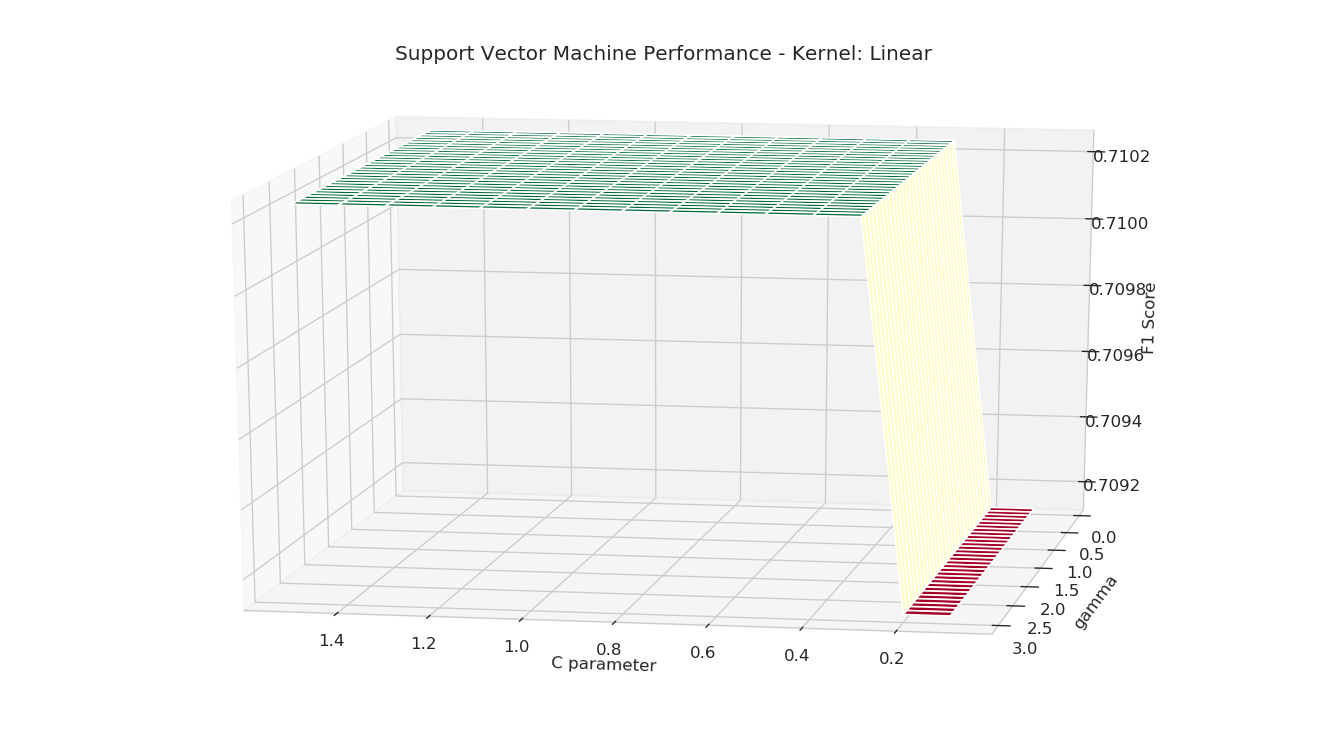

SVM F1-Score plateaus at an expected value of 0.7102 when using the linear kernel and the 
inverse of regularization strength parameter C is equal to or greater than 0.3.


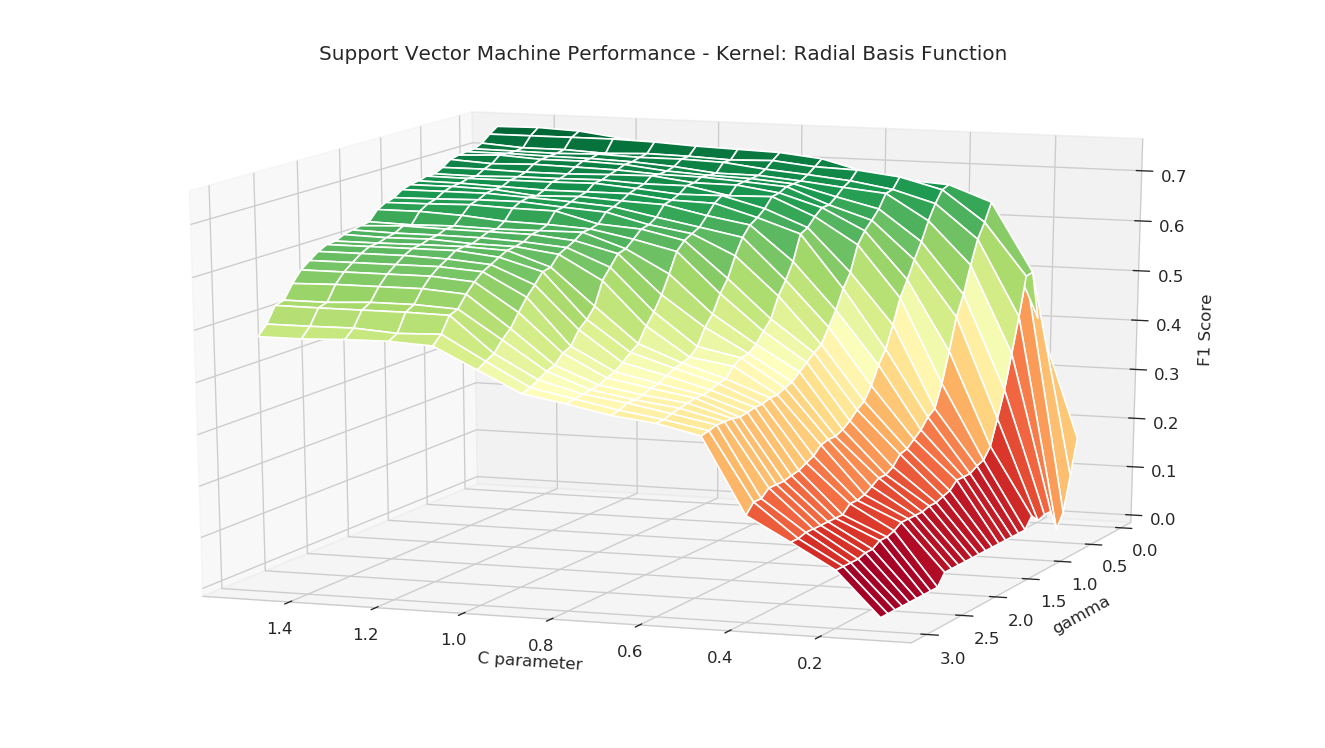

SVM F1-Score increases for small gamma values and an increasing regularization strength parameter C, 
reaching an an expected maxiumum value of 0.7476 when using the radial basis function kernel 
with C parameter = 1.4 and gamma = 0.05.


In [198]:
X, Y = np.meshgrid(C_range, gamma_range)
Z = lin_scores
fig=plt.figure(figsize=(14, 8), dpi= 120, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap="RdYlGn")
ax.view_init(azim=100, elev=15)
ax.set_zlabel('F1 Score')
ax.set_ylabel('gamma')
ax.set_xlabel('C parameter')
plt.title('Support Vector Machine Performance - Kernel: Linear')
plt.show()
print("SVM F1-Score plateaus at an expected value of "+str(round(lin_scores[5,14],4))+" when using the linear kernel and the \ninverse of regularization strength parameter C is equal to or greater than "+str(C_range[2])+".")

X, Y = np.meshgrid(C_range, gamma_range)
Z = rbf_scores
fig=plt.figure(figsize=(14, 8), dpi= 120, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap="RdYlGn")
ax.view_init(azim=110, elev=15)
ax.set_zlabel('F1 Score')
ax.set_ylabel('gamma')
ax.set_xlabel('C parameter')
plt.title('Support Vector Machine Performance - Kernel: Radial Basis Function')
plt.show()
print("SVM F1-Score increases for small gamma values and an increasing regularization strength parameter C, \nreaching an an expected maxiumum value of "+str(round(rbf_scores[0,13],4))+" when using the radial basis function kernel \nwith C parameter = "+str(C_range[13])+" and gamma = "+str(gamma_range[0])+".")

## Load Test Data and Generate Predictions

Use our trained and optimized models to predict suvival for passengers in the "test.csv". Compare the outputs of the two model predictors.

### Create Fine-Tuned Classification Models

In [250]:
from sklearn.svm import SVC
svc = SVC(kernel='rbf', C=1.4, gamma=0.05)  # Instantiate model object using optimal parameters

features = ["Pclass","Sex","Age","FareZ", "SibSp", "Parch"]
target = ["Survived"]

cv_score = cross_val_score(svc, df[features], df[target].values.ravel(), cv=cv_folds, scoring=scoring_method)
print("Mean cross validation score for optimized model: "+str(round(np.mean(cv_score),4)))

Mean cross validation score for optimized model: 0.7476


In [251]:
svc = SVC(kernel='rbf', C=1.4, gamma=0.05)  # Instantiate model object using optimal parameters
svc.fit(df[features], df[target].values.ravel())  # Fit model using all available training data

SVC(C=1.4, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.05, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

### Load Test Data and Prepare it for Input to Model

In [252]:
test_df = pd.read_csv(os.path.join('source_data', 'test.csv'))  # Read in the Test data supplied by kaggle
test_df.head()  # same as train.csv except for the missing Survived column

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [253]:
features = ["Pclass","Sex","Age","FareZ", "SibSp", "Parch"]
target = ["Survived"]

sex_mapping = {'male': 0, 'female': 1}  # Codify and map Sex strings to integer values
test_df['Sex'] = test_df['Sex'].map(sex_mapping)
test_df["Age"].fillna(28.0, inplace=True)  # Replace null data in Age column with the median Age = 28.0
test_df["Fare"].fillna(14.5, inplace=True)  # Replace null data in Fare column with the median Fare = 14.5
test_df['FareZ'] = (test_df['Fare'] - test_df['Fare'].mean()) / test_df['Fare'].std()

In [256]:
# Predict 
test_predictions = svc.predict(test_df[features])
test_df['Survived'] = test_predictions

In [ ]:
features = ["Pclass","Sex","Age","FareZ", "SibSp", "Parch"]
target = ["Survived"]

### Create and Train Best Model to Make Predictions on Test Data

In [ ]:
# Replace this LogisticRegression(C=1.0) with your own best model!
clf = LogisticRegression(C=1.0)
clf.fit(X, y)
test_predictions = clf.predict(X_test)

### Create Submission File

In [257]:
test_df[['PassengerId', 'Survived']].to_csv('submission.csv', index=False)

The competition scored my results as follows:
<ol><li><b>SVM Classifier</b>: 0.76555</li>
    <li><b>kNN Classifier</b>: 0.74162</li></ol>

In [ ]:
test_df['Survived'] = test_predictions
test_df[['PassengerId', 'Survived']].to_csv('submission.csv', index=False)